# Mount the drive

In [3]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/DDoS Detection/DDoS_dataset.csv'

Mounted at /content/drive


# Import the necessary libraries and framework

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score, confusion_matrix

# Create the dataframe

In [5]:
df = pd.read_csv(file_path)
print(df.shape)
df.head()

(852585, 9)


,Highest Layer,Transport Layer,Source IP,Dest IP,Source Port,Dest Port,Packet Length,Packets/Time,target
0,ARP,UDP,1,192.168.1.1,0,0,60,92.8,1
1,ARP,UDP,0,192.168.1.10,0,0,42,92.9,0
2,ARP,UDP,1,192.168.1.1,0,0,60,362.8,1
3,ARP,UDP,0,192.168.1.12,0,0,42,362.8,0
4,ARP,UDP,1,192.168.1.1,0,0,60,364.3,1


# Check Null and NaN values in the dataset

In [6]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print()
print(df.info())

Dataset Shape: (852585, 9)

Missing Values:
 Highest Layer      0
Transport Layer    0
Source IP          0
Dest IP            0
Source Port        0
Dest Port          0
Packet Length      0
Packets/Time       0
target             0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 852585 entries, 0 to 852584
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Highest Layer    852585 non-null  object 
 1   Transport Layer  852585 non-null  object 
 2   Source IP        852585 non-null  int64  
 3   Dest IP          852585 non-null  object 
 4   Source Port      852585 non-null  int64  
 5   Dest Port        852585 non-null  int64  
 6   Packet Length    852585 non-null  int64  
 7   Packets/Time     852585 non-null  float64
 8   target           852585 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 58.5+ MB
None


# Pre-processing

In [7]:
# Separate numerical and categorical features
numerical_features = df.select_dtypes(include=['number'])
categorical_features = df.select_dtypes(include=['object'])

# Apply Label Encoding to categorical features
label_encoder = LabelEncoder()

# Apply label encoding to each categorical column
for column in categorical_features.columns:
    df[column] = label_encoder.fit_transform(categorical_features[column])

print("Categorical Features after Label Encoding:")
print(categorical_features)
print(df.head())

Categorical Features after Label Encoding:
       Highest Layer Transport Layer       Dest IP
0                ARP             UDP   192.168.1.1
1                ARP             UDP  192.168.1.10
2                ARP             UDP   192.168.1.1
3                ARP             UDP  192.168.1.12
4                ARP             UDP   192.168.1.1
...              ...             ...           ...
852580          DATA             UDP   192.168.1.1
852581          DATA             UDP   192.168.1.1
852582          DATA             UDP   192.168.1.1
852583          DATA             UDP   192.168.1.1
852584          DATA             UDP   192.168.1.1

[852585 rows x 3 columns]
   Highest Layer  Transport Layer  Source IP  Dest IP  Source Port  Dest Port  \
0              0                1          1        5            0          0   
1              0                1          0        6            0          0   
2              0                1          1        5            0         

In [8]:
y = df['target']
X = df.drop(columns=['target', 'Source IP', 'Dest IP'])

# Split the data into train + validation and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
# Check the balance of the target column
target_balance = df['target'].value_counts()

print("Target Balance:")
print(target_balance)

target_percentage = df['target'].value_counts(normalize=True) * 100
print("\nTarget Percentage:")
print(target_percentage)

Target Balance:
target
0    454849
1    397736
Name: count, dtype: int64

Target Percentage:
target
0    53.349402
1    46.650598
Name: proportion, dtype: float64


# EDA

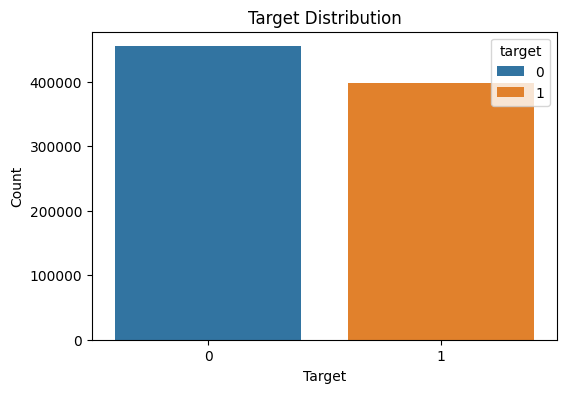

In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df, hue='target')

plt.title('Target Distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

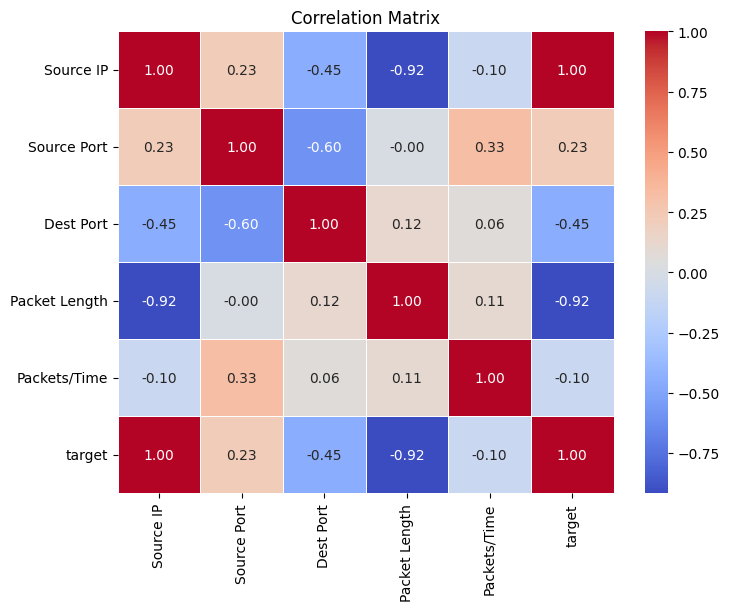

In [19]:
corr_matrix = numerical_features.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

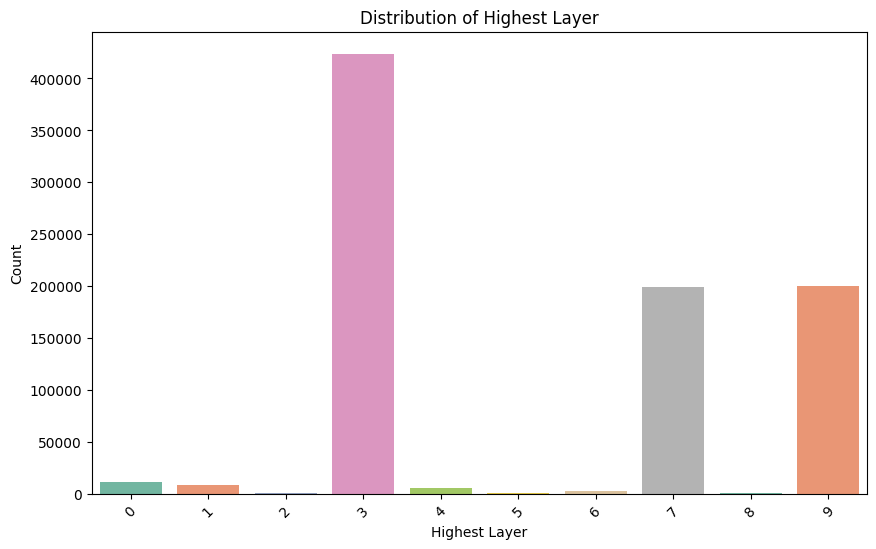

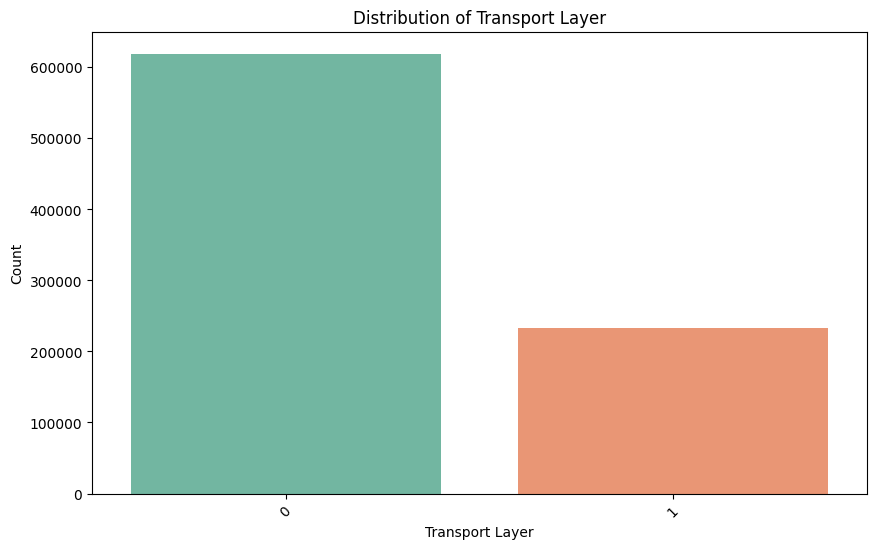

In [28]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Highest Layer', data=df, hue='Highest Layer', palette='Set2', legend=False)
plt.title('Distribution of Highest Layer')
plt.xlabel('Highest Layer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Transport Layer', data=df, hue='Transport Layer', palette='Set2', legend=False)
plt.title('Distribution of Transport Layer')
plt.xlabel('Transport Layer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

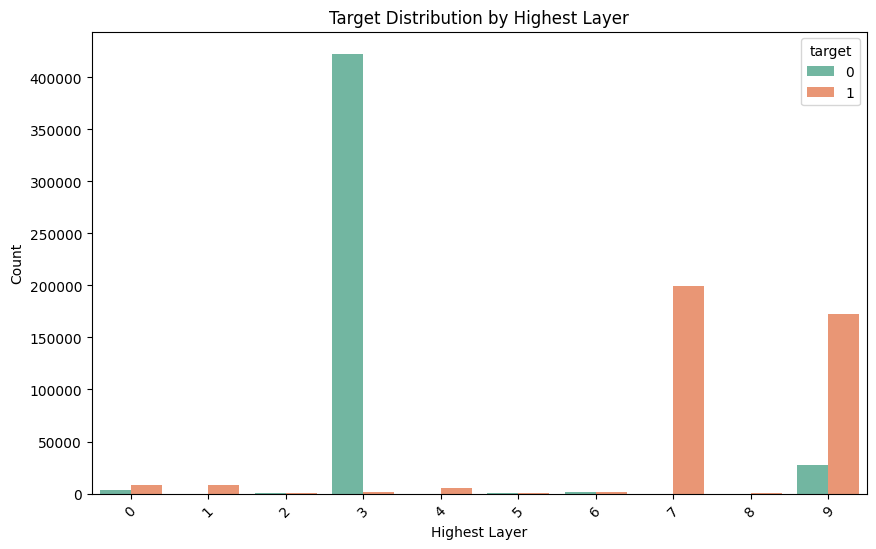

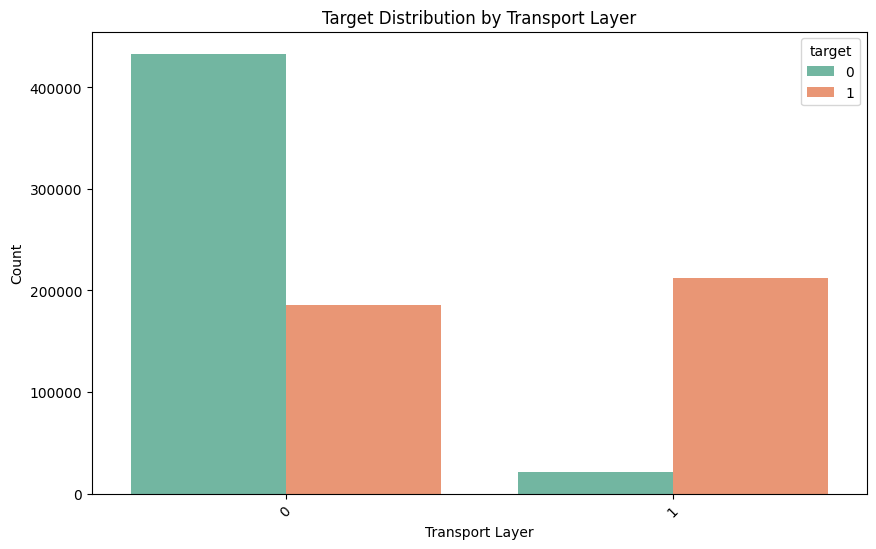

In [30]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Highest Layer', hue='target', data=df, palette='Set2', legend=True)
plt.title('Target Distribution by Highest Layer')
plt.xlabel('Highest Layer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Transport Layer', hue='target', data=df, palette='Set2', legend=True)
plt.title('Target Distribution by Transport Layer')
plt.xlabel('Transport Layer')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Hyperparamter tuning

## Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(max_iter=10000)

lr_param_grid = {
    'C': [0.1, 1],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs'],
}

lr_grid_search = GridSearchCV(estimator=lr, param_grid=lr_param_grid, cv=3, n_jobs=-1)
lr_grid_search.fit(X_train_scaled, y_train)

print("Logistic Regression Best Parameters:", lr_grid_search.best_params_)
print("Logistic Regression Best Score:", lr_grid_search.best_score_)

Logistic Regression Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Logistic Regression Best Score: 0.994377393456371


## Support Vector Machine

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

svm = LinearSVC(max_iter=10000, dual=False)

svm_param_grid = {
    'C': [0.01, 0.1, 1, 10],
}

svm_random_search = RandomizedSearchCV(estimator=svm, param_distributions=svm_param_grid, n_iter=3, cv=2, n_jobs=-1, verbose=1)
svm_random_search.fit(X_train_scaled, y_train)

print("SVM Best Parameters:", svm_random_search.best_params_)
print("SVM Best Score:", svm_random_search.best_score_)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
SVM Best Parameters: {'C': 0.01}
SVM Best Score: 0.9943348757015429


## Random Forest

In [12]:
rf = RandomForestClassifier()

rf_param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_param_grid, cv=3, n_jobs=-1)
rf_grid_search.fit(X_train_scaled, y_train)

print("Random Forest Best Parameters:", rf_grid_search.best_params_)
print("Random Forest Best Score:", rf_grid_search.best_score_)

Random Forest Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Random Forest Best Score: 0.9980559123137281


## Extreme Gradient Boosting

In [13]:
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

xgb_param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, cv=3, n_jobs=-1)
xgb_grid_search.fit(X_train_scaled, y_train)

print("XGBoost Best Parameters:", xgb_grid_search.best_params_)
print("XGBoost Best Score:", xgb_grid_search.best_score_)

XGBoost Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
XGBoost Best Score: 0.9981468123412914


# Model Training

In [14]:
best_params = {
    "LogisticRegression": {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'},
    "SVM": {'C': 0.01},
    "RandomForest": {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},
    "XGBoost": {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
}

models = {
    "LogisticRegression": LogisticRegression(**best_params["LogisticRegression"]),
    "SVM": LinearSVC(**best_params["SVM"], dual=False, max_iter=5000),
    "RandomForest": RandomForestClassifier(**best_params["RandomForest"], random_state=42),
    "XGBoost": xgb.XGBClassifier(**best_params["XGBoost"], use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}


Training LogisticRegression...

LogisticRegression Accuracy: 0.9947
LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     90785
           1       0.99      1.00      0.99     79732

    accuracy                           0.99    170517
   macro avg       0.99      0.99      0.99    170517
weighted avg       0.99      0.99      0.99    170517



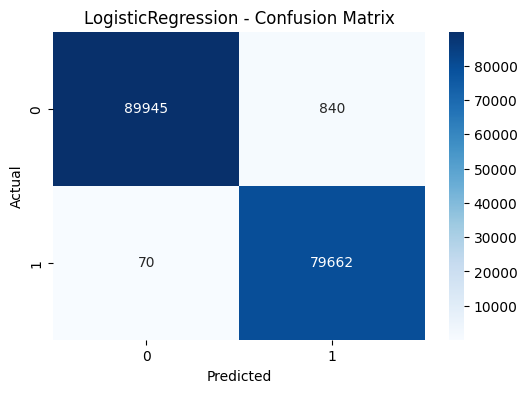


Training SVM...

SVM Accuracy: 0.9943
SVM Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     90785
           1       0.99      1.00      0.99     79732

    accuracy                           0.99    170517
   macro avg       0.99      0.99      0.99    170517
weighted avg       0.99      0.99      0.99    170517



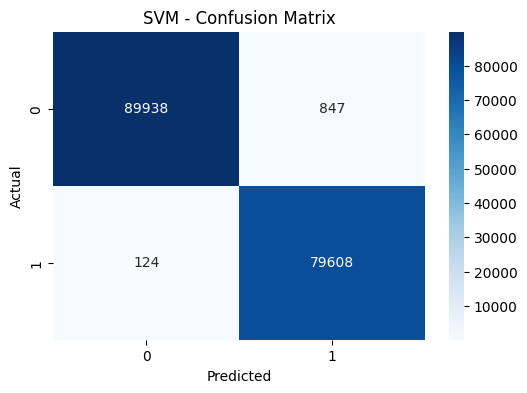


Training RandomForest...

RandomForest Accuracy: 0.9979
RandomForest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     90785
           1       1.00      1.00      1.00     79732

    accuracy                           1.00    170517
   macro avg       1.00      1.00      1.00    170517
weighted avg       1.00      1.00      1.00    170517



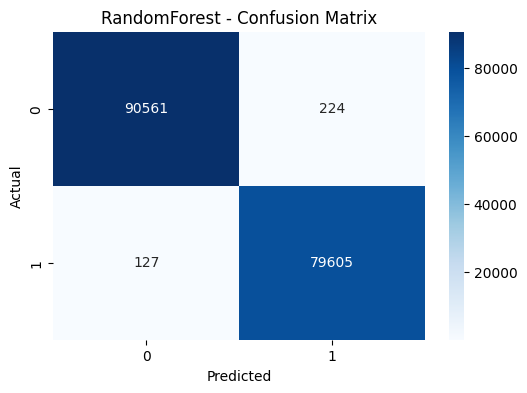


Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:08:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Accuracy: 0.9980
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     90785
           1       1.00      1.00      1.00     79732

    accuracy                           1.00    170517
   macro avg       1.00      1.00      1.00    170517
weighted avg       1.00      1.00      1.00    170517



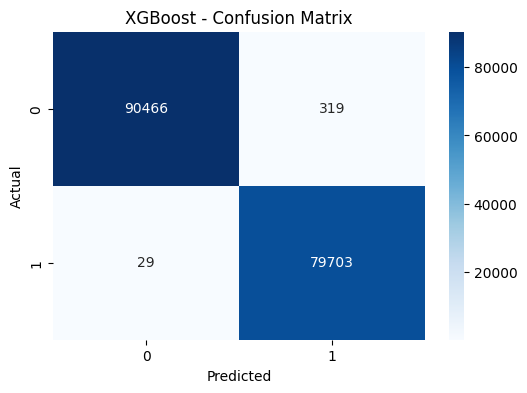

In [15]:
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

    print(f"\n{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

    plt.figure(figsize=(6,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{name} - Confusion Matrix')
    plt.show()

In [16]:
df_results = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
df_results.sort_values(by='Accuracy', ascending=False, inplace=True)
print("\n Model Performance Comparison:\n")
print(df_results)


 Model Performance Comparison:

                    Accuracy
XGBoost             0.997959
RandomForest        0.997942
LogisticRegression  0.994663
SVM                 0.994306


# Save the models

In [17]:
import joblib

# Directory to store models
import os
os.makedirs("models", exist_ok=True)

# Save each model
for name, model in models.items():
    joblib.dump(model, f'models/{name}.pkl')

print("Models saved successfully!")

Models saved successfully!


# Load the models

In [18]:
# Load all models
loaded_models = {name: joblib.load(f'models/{name}.pkl') for name in models.keys()}

print("Models loaded successfully!")

Models loaded successfully!


# Download the models

In [19]:
from google.colab import files

for name in models.keys():
    files.download(f'models/{name}.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>